In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import math
import numpy as np
from scipy.fft import fft2
import scipy.stats as stats
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose

from package.analysis import ft
from package.helpers import test_lens, test_physical_lens
from package.plots import plot

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
with initialize(version_base=None, config_path='../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, repo_dir, pickle_dir = config.machine.array_dir, config.machine.data_dir, config.machine.repo_dir, config.machine.pickle_dir
array_dir = os.path.join(array_dir, 'multiprocessing')
figure_dir = os.path.join(repo_dir, 'figures')

In [4]:
one = np.load(os.path.join(array_dir, 'detector_1.npy'))
three = np.load(os.path.join(array_dir, 'detector_3.npy'))
five = np.load(os.path.join(array_dir, 'detector_5.npy'))
seven = np.load(os.path.join(array_dir, 'detector_7.npy'))
nine = np.load(os.path.join(array_dir, 'detector_9.npy'))

image = nine

[Source](https://stackoverflow.com/questions/54410356/plot-the-psd-of-an-image-vs-x-y-axis)

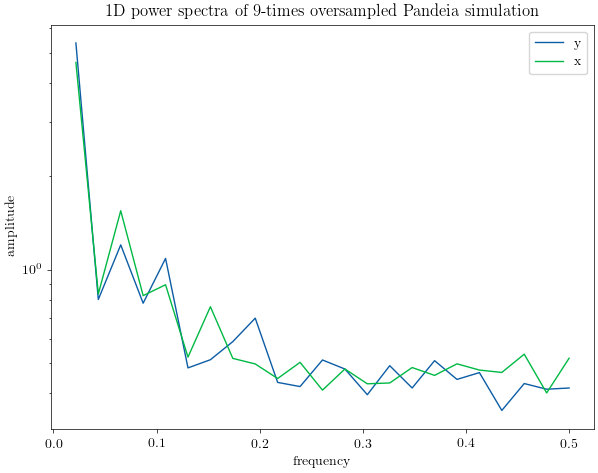

In [5]:
# Fourier Transform along the first axis

# TODO get into the right units of inverse arcseconds

# Round up the size along this axis to an even number
n = int( math.ceil(image.shape[0] / 2.) * 2 )

# We use rfft since we are processing real values
y = np.fft.rfft(image,n, axis=0)

# Sum power along the second axis
y = y.real*y.real + y.imag*y.imag
y = y.sum(axis=1)/y.shape[1]

# Generate a list of frequencies
fy = np.fft.rfftfreq(n)

# Graph it
plt.plot(fy[1:],y[1:], label ='y')

# Fourier Transform along the second axis

# Same steps as above
n = int( math.ceil(image.shape[1] / 2.) * 2 )

x = np.fft.rfft(image,n,axis=1)

x = x.real*x.real + x.imag*x.imag
x = x.sum(axis=0)/x.shape[0]

fx = np.fft.rfftfreq(n)

plt.plot(fx[1:],x[1:], label='x')

plt.title('1D power spectra of 9-times oversampled Pandeia simulation')
plt.ylabel('amplitude')
plt.xlabel('frequency')
plt.yscale('log')
plt.legend()

plt.show()

[Source](https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/)

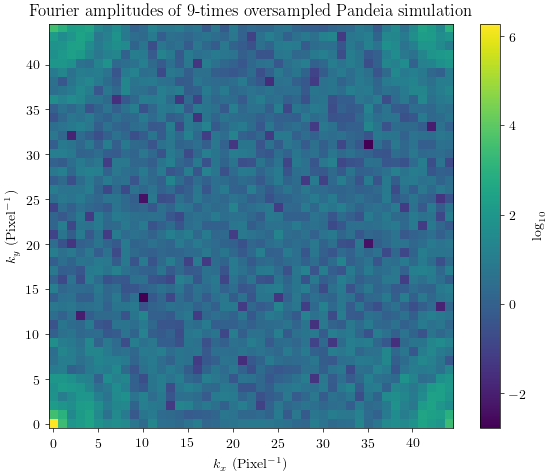

In [6]:
npix = image.shape[0]

fourier_image = np.fft.fftn(image)
fourier_amplitudes = np.abs(fourier_image)**2

plt.imshow(np.log10(fourier_amplitudes))
plt.title('Fourier amplitudes of 9-times oversampled Pandeia simulation')
plt.xlabel('$k_x$ (Pixel$^{-1}$)')
plt.ylabel('$k_y$ (Pixel$^{-1}$)')
cbar = plt.colorbar()
cbar.set_label('$\log_{10}$')
plt.show()

In [7]:
kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

In [8]:
knrm = knrm.flatten()
fourier_amplitudes_flat = fourier_amplitudes.flatten()

In [9]:
kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes_flat,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

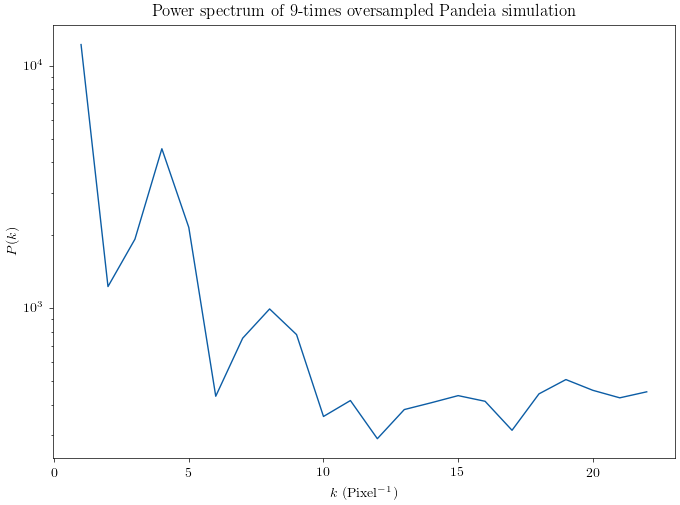

In [10]:
plt.plot(kvals, Abins)
plt.title('Power spectrum of 9-times oversampled Pandeia simulation')
plt.xlabel("$k$ (Pixel$^{-1})$")
plt.ylabel("$P(k)$")
# plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.show()

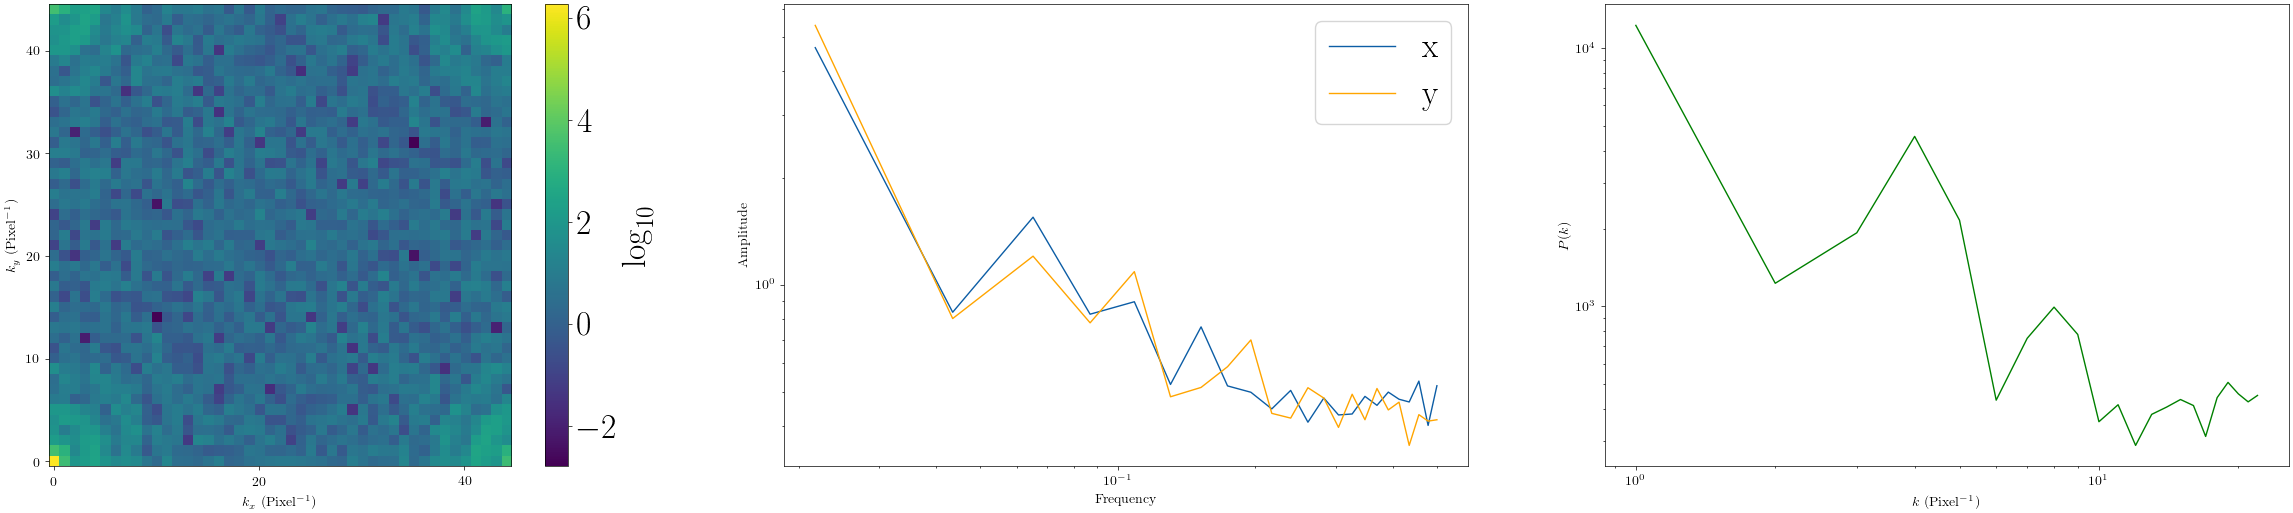

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

import matplotlib
fontsize = 24
matplotlib.rcParams.update({'font.size': fontsize})

ax0 = ax[0].imshow(np.log10(fourier_amplitudes))
ax1 = ax[1].plot(fx[1:],x[1:], label='x')
ax[1].plot(fy[1:],y[1:], label='y', color='orange')
ax2 = ax[2].plot(kvals, Abins, color='g')

# ax[0].set_title('Fourier amplitudes of 9-times oversampled Pandeia simulation')
# ax[1].set_title('1D power spectra of 9-times oversampled Pandeia simulation')
# ax[2].set_title('Power spectrum of 9-times oversampled Pandeia simulation')

cbar = plt.colorbar(ax0, ax=ax[0])
cbar.set_label('$\log_{10}$')
ax[0].set_xlabel('$k_x$ (Pixel$^{-1}$)')
ax[0].set_ylabel('$k_y$ (Pixel$^{-1}$)')

ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_xlabel("$k$ (Pixel$^{-1})$")
ax[2].set_ylabel("$P(k)$")
ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.savefig(os.path.join(figure_dir, 'power_spectrum.png'))
plt.show()